In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/My Drive/loader_util.zip"

Archive:  /content/drive/My Drive/loader_util.zip
   creating: loader_util/
   creating: loader_util/callbacks/
  inflating: loader_util/callbacks/epochcheckpoint.py  
  inflating: loader_util/callbacks/trainingmonitor.py  
  inflating: loader_util/callbacks/__init__.py  
   creating: loader_util/callbacks/__pycache__/
  inflating: loader_util/callbacks/__pycache__/epochcheckpoint.cpython-36.pyc  
  inflating: loader_util/callbacks/__pycache__/trainingmonitor.cpython-36.pyc  
  inflating: loader_util/callbacks/__pycache__/__init__.cpython-36.pyc  
   creating: loader_util/datasets/
  inflating: loader_util/datasets/simpledatasetloader.py  
  inflating: loader_util/datasets/torch_dataset_loader.py  
  inflating: loader_util/datasets/torch_train_test_split.py  
  inflating: loader_util/datasets/__init__.py  
   creating: loader_util/datasets/__pycache__/
  inflating: loader_util/datasets/__pycache__/simpledatasetloader.cpython-36.pyc  
  inflating: loader_util/datasets/__pycache__/torch_

In [5]:
import os
import h5py
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from imutils import paths
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [6]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor, \
    AspectAwarePreprocessor, MeanSubtractionPreProcessor, SimplePreProcessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.io import HDF5DatasetGenerator
from loader_util.nn.conv import FCHeadNet, LeNet, AlexNet, MinVGGNet, MiniGoogleNet, DeeperGoogleNet
from loader_util.callbacks import TrainingMonitor, EpochCheckpoint
##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler

In [7]:
# construct the train image generator
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode='nearest')

In [8]:
batch_size = 32
epoch_num = 500
image_size = 28

# initialise the image preprocessors
sp = SimplePreProcessor(width=image_size, height=image_size)
iap = ImageToArrayPreprocessor()

In [9]:
# initialise the data paths

dbBase = r"/content/drive/My Drive"
dbTrainPath = f"{dbBase}//train_mvcnn_color_roi_10class_28px1px_255.hdf5"
dbValidPath = f"{dbBase}//test_mvcnn_color_roi_10class_28px1px_255.hdf5"

# get the no. of classes
trainFile = h5py.File(name=dbTrainPath, mode="r")
class_num = len(list(np.unique(trainFile["labels"])))
print(f"Total no. of classes in dataset: {class_num}")

# get unique labels
labels = list(trainFile["label_names"])
labels = [label.decode() for label in labels]
print(f"Unique Labels: {labels}")

Total no. of classes in dataset: 10
Unique Labels: ['Brackets', 'Bulky', 'Cylindrical', 'Gasket', 'HeadlessScrews', 'Nuts', 'O-Rings', 'Pipes', 'Springs', 'Toothy']


In [10]:
# consider class weight discrepency
le = LabelEncoder()
labels = le.fit_transform(trainFile["labels"])
encoded_labels = to_categorical(labels)

classLabels = le.classes_
classTotals = encoded_labels.sum(axis=0) # type: np.ndarray
classWeight = classTotals.max() / classTotals

print(f"ClassLabels: {classLabels}")
print(f"ClassWeights: {classWeight}")

ClassLabels: [0 1 2 3 4 5 6 7 8 9]
ClassWeights: [5.9427314 2.48893   4.014881  4.401305  2.0850077 3.6508796 1.
 3.3809524 1.4536638 4.870036 ]


In [11]:
# initialise the train and valid generators
trainGen = HDF5DatasetGenerator(dbPath=dbTrainPath,
                                batchSize=batch_size,
                                preprocessors=[sp, iap],
                                classes=class_num,
                                aug=aug)

valGen = HDF5DatasetGenerator(dbPath=dbValidPath,
                              batchSize=batch_size,
                              preprocessors=[sp, iap],
                              classes=class_num)

In [12]:
# define the Learning Rate Scheduler

initial_rate = 5e-3

def poly_decay(epoch):
    max_epochs = epoch_num
    baseLR = initial_rate
    power = 1.0
    
    alpha = baseLR * (1 - (epoch / float(max_epochs))) ** power
    return alpha

In [13]:
# model = AlexNet.build(width=32, height=32, depth=3, classes=class_num)
model = LeNet.build(width=28,
                    height=28,
                    depth=1,
                    classes=len(classLabels))

# model = MinVGGNet.build(width=28,
#                     height=28,
#                     depth=1,
#                     classes=len(classLabels))

# model = MiniGoogleNet.build(width=28, height=28, depth=1, classes=class_num)
#model =DeeperGoogleNet.build(width=image_size, height=image_size, depth=1, classes=class_num)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 20)        520       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2450)              0

In [16]:
# compile and optimise model
opt = Adam(lr=initial_rate)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# construct callbacks
path = os.path.sep.join([dbBase, f'{os.getpid()}.png'])
callbacks = [TrainingMonitor(path),
             LearningRateScheduler(poly_decay),]
             #EpochCheckpoint(outputPath=dbBase)]

In [17]:

classWeight = {i : classWeight[i] for i in range(len(classWeight))}
classWeight

{0: 5.9427314,
 1: 2.48893,
 2: 4.014881,
 3: 4.401305,
 4: 2.0850077,
 5: 3.6508796,
 6: 1.0,
 7: 3.3809524,
 8: 1.4536638,
 9: 4.870036}

In [18]:
# train the head for few epochs
H = model.fit_generator(
    trainGen.generator(),
    steps_per_epoch=trainGen.numImages//batch_size,
    validation_data=valGen.generator(),
    validation_steps=valGen.numImages//batch_size,
    epochs=epoch_num,
    max_queue_size=10,
    verbose=1,
    callbacks=callbacks,
    # class_weight=classWeight
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/500
336/336 [==============================] - 4s 13ms/step - loss: 1.8410 - accuracy: 0.3577 - val_loss: 1.2901 - val_accuracy: 0.5438
Epoch 2/500
336/336 [==============================] - 4s 13ms/step - loss: 1.2532 - accuracy: 0.5669 - val_loss: 0.8643 - val_accuracy: 0.7120
Epoch 3/500
336/336 [==============================] - 4s 13ms/step - loss: 0.9557 - accuracy: 0.6675 - val_loss: 0.6975 - val_accuracy: 0.7465
Epoch 4/500
336/336 [==============================] - 4s 13ms/step - loss: 0.7926 - accuracy: 0.7223 - val_loss: 0.6098 - val_accuracy: 0.7912
Epoch 5/500
336/336 [==============================] - 5s 13ms/step - loss: 0.7967 - accuracy: 0.7227 - val_loss: 0.6111 - val_accuracy: 0.7839
Epoch 6/500
336/336 [==============================] - 4s 13ms/step - loss: 0.6933 - accuracy: 0.7588 - val_loss: 0.5369 - val_accuracy: 0.8255
Epoch 7/500
336/336 [==============================] - 4s 13

In [19]:
# save the model
model.save(f"{dbBase}//model_mvcnn_color_roi_10class_28px1px_threshinv_255.h5")

In [20]:
# calculate the classification report
from tensorflow.keras.utils import to_categorical
validDB = h5py.File(dbValidPath, mode="r")
testx = validDB["images"][:]
testy = to_categorical(validDB["labels"][:], class_num)
preds = model.predict(testx, batch_size=batch_size)
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       194
           1       0.85      0.89      0.87       464
           2       0.94      0.85      0.89       288
           3       0.99      0.99      0.99       263
           4       0.96      0.95      0.95       554
           5       0.99      1.00      1.00       317
           6       0.99      1.00      1.00      1157
           7       0.98      0.99      0.99       342
           8       0.94      0.96      0.95       796
           9       0.94      0.87      0.90       238

    accuracy                           0.96      4613
   macro avg       0.95      0.95      0.95      4613
weighted avg       0.96      0.96      0.96      4613



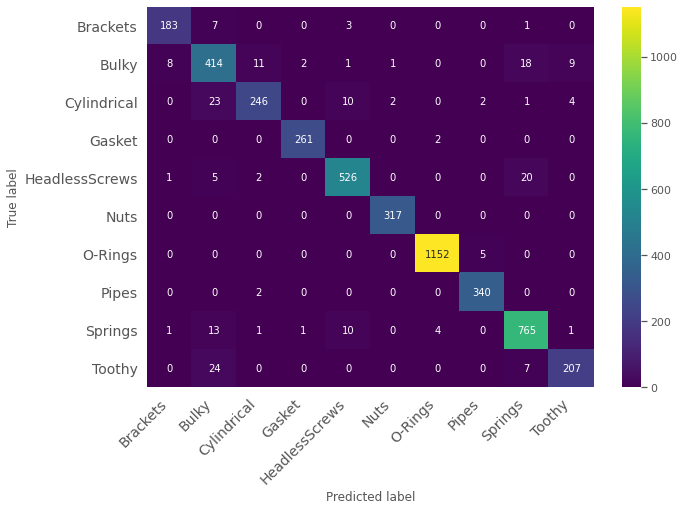

In [28]:
# print confusion matrix
labels = list(trainFile["label_names"])
labels = [label.decode() for label in labels]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testy.argmax(axis=1),
                      preds.argmax(axis=1))

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print_confusion_matrix(cm, class_names=labels)

In [26]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])